In [4]:
 #Some basic imports
from __future__ import print_function
#To make the plots inline otherwise it will make seperate figure
%matplotlib inline 
#for high resolution plot outputs
%config InlineBackend.figure_format = 'retina'

import pickle
import numpy as np
import pylab as pl
import fitsio as F
import time

from datetime import date

import os
import sys

In [5]:
#please do not change this directory unless you know what you are doing
main_code_dir='/global/u1/s/shadaba/Projects/SV3/CorrelationFunction/'

In [6]:
 def make_dir(dirin):
    '''checks and creates a directory'''
    if(not os.path.isdir(dirin)):
        os.mkdir(dirin)
        print('created: ',dirin)
    else:
        print('Already exists: ',dirin)
        
    return

In [7]:
#xidir='path to your output directory'
xidir='test/'
slurmdir = 'slurm/'
make_dir(xidir) 
make_dir(slurmdir)

Already exists:  test/
Already exists:  slurm/


In [8]:
 # This creates all the needed sub-direcotries so that code can work without hassles



def setup_directory_tree(xidir):
    '''This setups the directory tree'''
    global pcdir, wpdir,xi2ddir,xi02dir
    pcdir=xidir+'PairCount/'
    wpdir=xidir+'WP/'
    xi2ddir=xidir+'XI2D/'
    xi02dir=xidir+'XI02/'
    
    for td in [xidir,pcdir, wpdir,xi2ddir,xi02dir]:
        make_dir(td)

    return

setup_directory_tree(xidir)

Already exists:  test/
Already exists:  test/PairCount/
Already exists:  test/WP/
Already exists:  test/XI2D/
Already exists:  test/XI02/


In [9]:
def tracer_program(tracer):
    if('BGS' in tracer or 'MWS' in tracer):
        return 'BRIGHT'
    else:
        return 'DARK'
    
def get_outroot(selection='TARGET',tracer='LRG',sky='N',wtag='w1',xitype='angular'):
    if(xitype=='angular'):
        outroot='%s%s_%s_%s_%s'%(pcdir,tracer_key(tracer),sky,selection,wtag)
    else:
        outroot='%s%s_%s_%s_%s_z1z2_'%(pcdir,tracer_key(tracer),sky,selection,wtag)
        
    return outroot

def config_file(config_dir,tracer,sky,xitype,wtag,zsel,tracer2=None):
    if(zsel is not None):
        ztag='_z1z2_%4.2f_%4.2f'%(zsel[0],zsel[1])
    else:
        ztag=''
    
    if(tracer2 is None):
        outfile='%s%s_%s_%s_%s%s.ini'%(config_dir,tracer,sky,xitype,wtag,ztag)
    else:
        outfile='%scross%sx%s_%s_%s_%s%s.ini'%(config_dir,tracer,tracer2,sky,xitype,wtag,ztag)
    
    return outfile

def prepare_config_file(tracer,sky,wtag='w1',xitype='angular',zsel=None,config_dir='config_desi_sv3/',
                       tracer2=None):
    
    '''prepares the configuration files
    provide tracer 2 and wtag2 if cross-correlation is needed'''
    
    if(zsel is not None):
        zsel_str='z1z2 = %4.2f, %4.2f'%(zsel[0],zsel[1])
    else:
        zsel_str=''
    
    outfile=config_file(config_dir,tracer,sky,xitype,wtag,zsel,tracer2=tracer2)
    
    program=tracer_program(tracer)
    with open(outfile,'w') as fout:
        if(tracer2 is None):
            fout.write('import_config1 = %sconfig_desi_glob/%s_global.ini\n'%(main_code_dir,xitype))
            fout.write('import_config2 = %sconfig_desi_glob/%s_catalog.ini\n'%(main_code_dir,program))
        else:
            fout.write('import_config1 = %sconfig_desi_glob/cross%s_global.ini\n'%(main_code_dir,xitype))
            fout.write('import_config2 = %sconfig_desi_glob/cross%s_catalog.ini\n'%(main_code_dir,program))

        fout.write(zsel_str)
            
        fout.write('\n\noutdir = %s\n\n'%(xidir))
        
        fout.write('\n\n#parameters for the this catalogue\n')
        fout.write('[sv3_desi]\n')
        fout.write('PROGRAM = %s\n'%program)
        fout.write('tracer = %s\n'%tracer)
        fout.write('sky = %s\n'%sky)
        fout.write('#This decides the weighting w1 is unit weight wsys is sys weight\n')
        fout.write('wtag = %s\n'%wtag)
        
        if(tracer2 is not None):
            fout.write('\n\n#parameters for the second catalogue\n')
            fout.write('[sv3_desi2]\n')
            fout.write('PROGRAM = %s\n'%program)
            fout.write('tracer = %s\n'%tracer2)
            fout.write('sky = %s\n'%sky)
            fout.write('#This decides the weighting w1 is unit weight wsys is sys weight\n')
            fout.write('wtag = %s\n'%wtag)   
               
    return outfile


In [10]:
config_dir='tmp_config_desi_sv3/'
make_dir(config_dir)

Already exists:  tmp_config_desi_sv3/


In [11]:
def slurm_script_shared(outfile,comm,ncpu=4,time=None):
    with open(outfile,'w') as fout:
        fout.write('#!/bin/bash\n')
        fout.write('#SBATCH --qos=shared\n')
        fout.write('#SBATCH --constraint=haswell\n')
        if(time is None):
            time='01:00:00'
            
        fout.write('#SBATCH --time=%s\n'%time)
        
        fout.write('#SBATCH --nodes=1\n')
        fout.write('#SBATCH --ntasks=1\n')
        fout.write('#SBATCH --cpus-per-task=%s\n'%ncpu)
        
        fout.write('\nsource /project/projectdirs/desi/software/desi_environment.sh master \n')
        
        for tcomm in comm:
            fout.write('srun --cpu-bind=cores %s \n'%tcomm)
        
    print('sbatch %s'%outfile)
    
    return

In [ ]:
## run this cell to enter a job que
os.system('salloc -N 1 -C haswell -t 00:30:00 --ntasks 1 --cpus-per-task=8 --qos shared --account desi')

# wait for the job to be allocated if it takes too long then change --qos shared to --qos debug


In [12]:
## run this once 
os.system('source /global/cfs/cdirs/desi/software/desi_environment.sh master')

0

In [26]:
def get_redshift_plots(zsel,tracer,sky,xitype):
    
    conf_list = []
    
    for x in xitype:

        for i in zsel:
            
            conf_t = prepare_config_file(tracer,sky,wtag='wcompEdWsys',xitype=x,zsel=i,config_dir=config_dir,tracer2=None)



            if (not os.path.isfile(xi2ddir+f'{tracer}_{sky}_CLUSTERING_wcompEdWsys_z1z2_{i[0]}-{i[1]}-wp-logrp-pi-NJN-120.txt')):

                comm2='python %sRunme_Correlation.py -config_file %s -selection CLUSTERING'%(main_code_dir,conf_t)

                outfile='slurm-job-%s-%s-%s.sh'%(tracer,sky,x)
                slurm_script_shared(outfile,[comm2],ncpu=8,time=2)

                conf_list.append(conf_t)

                os.system(comm2)


            if x == 'wp':
                file = wpdir+f'{tracer}_{sky}_CLUSTERING_wcompEdWsys_z1z2_{i[0]}-{i[1]}-wp-logrp-pi-NJN-120.txt'

                data = np.loadtxt(file)

                pl.errorbar(data[:,0],data[:,1],data[:,2],fmt='o',mfc='w',label=f'{x}, z = {i[0]}-{i[1]}')

            elif x == 'xi02':
                file1 = xi02dir+f'{tracer}_{sky}_CLUSTERING_wcompEdWsys_z1z2_{i[0]}-{i[1]}-xi0-rmu-NJN-120.txt'
                file2 = xi02dir+f'{tracer}_{sky}_CLUSTERING_wcompEdWsys_z1z2_{i[0]}-{i[1]}-xi2-rmu-NJN-120.txt' 

                data1 = np.loadtxt(file1)
                data2 = np.loadtxt(file2)

                pl.errorbar(data1[:,0],data1[:,1],data1[:,2],fmt='o',mfc='w',label=f'xi0, z = {i[0]}-{i[1]}')
                pl.errorbar(data2[:,0],data2[:,1],data2[:,2],fmt='o',mfc='w',label=f'xi2, z = {i[0]}-{i[1]}')

            elif x == 'xiwedge':
                file3 = xi2ddir+f'Wedge{tracer}_{sky}_CLUSTERING_wcompEdWsys_z1z2_{i[0]}-{i[1]}-logrmu-NJN-120.txt'

                data3 = np.loadtxt(file3)

                pl.errorbar(data3[:,0],data3[:,1],data3[:,2],fmt='o',mfc='w',label=f'{x}, z = {i[0]}-{i[1]}')
        
    pl.xscale('log')
    pl.yscale('log')

    pl.title(f' {xitype} {tracer} Multiple Redshifts,{zsel}')
    pl.xlabel(r'$r_\bot$ (Mpc/h)',fontsize=22)
    pl.ylabel(r'$w_p$',fontsize=22)
    pl.legend()
    
    os.system('mv *.sh slurm/')
    
    return

In [27]:
tracer='LRG'       #you can choose from LRG, ELG, QSO, BGS_ANY
sky='N'            #you can choose from N, S for north and South
xitype = 'wp','xi02'        #What statistic, you can choose from wp,xi02,xiwedge
zrange = [0.3,0.5],[0.6,0.8]

sbatch slurm-job-LRG-N-wp.sh
sbatch slurm-job-LRG-N-wp.sh
sbatch slurm-job-LRG-N-xi02.sh
sbatch slurm-job-LRG-N-xi02.sh


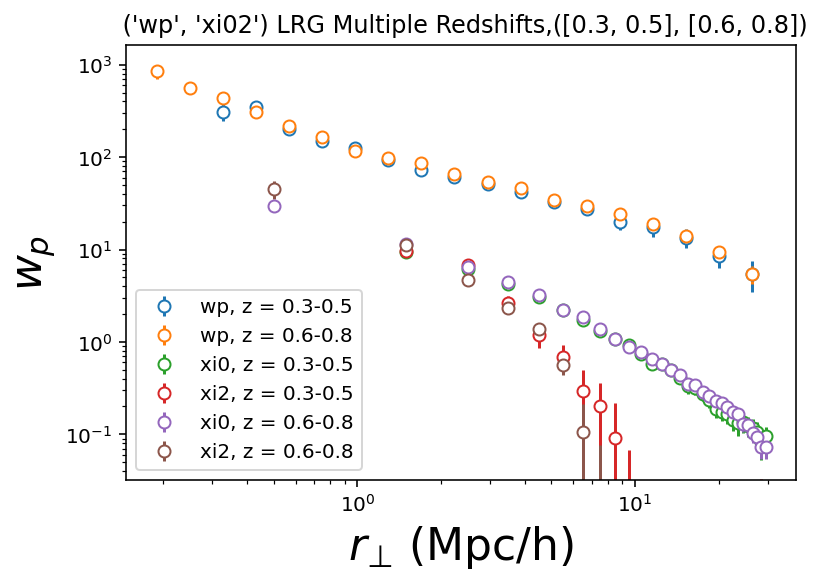

In [28]:
get_redshift_plots(zrange,tracer,sky,xitype)